# Erstellung einer Peakdatenbank

In [1]:
import alphatims.utils
import alphatims.bruker
import alphatims.plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Einlesen der Daten

We work with the Alphatims testdata.d and use the Bruker-September dataset later for validating our algorithm

In [65]:
name_dataset = 'testdata'

In [66]:
bruker_d_folder_name = "../Datasets/Alphatims-Testdata/%s.d" % name_dataset
data = alphatims.bruker.TimsTOF(bruker_d_folder_name)

## Generieren der nicht-spezifischen Randverteilung

In [67]:
# MS1 data
#precursor_indices = data[:, :, 0, "raw"]
precursor_indices = data[710.0:750.0, 1.02:1.06, 0, 900.0:1050.0, "raw"] # rt, mob, precursor, mz

# Da mit result = data.bin_intensities(precursor_indices, ("rt_values", "mz_values","mobility_values")) 31,7 TB RAM benötigt werden, gehen wir eindimensional vor
def bin_intensities(data, column):
    if column in ["mz_values"]:
        xaxis = data.mz_values
    elif column in ["rt_values"]:
        xaxis = data.rt_values
    elif column in ["mobility_values"]:
        xaxis = data.mobility_values
    else:
    # x-Achse
        exec("xaxis = data.%s" % column)
    # Funktion braucht zwei Inputspalten, daher wird die andere Spalte bestimmt
    column2 = "mz_values" if column !="mz_values" else "rt_values"
    # Berechne Randverteilung
    result = data.bin_intensities(precursor_indices, ("%s" % column, "%s" % column2))
    proj = [np.sum(result[i,:]) for i in range(result.shape[0])]
    # speichere Resultat in DataFrame
    df = pd.DataFrame({"x": xaxis, "y": proj})
    return df

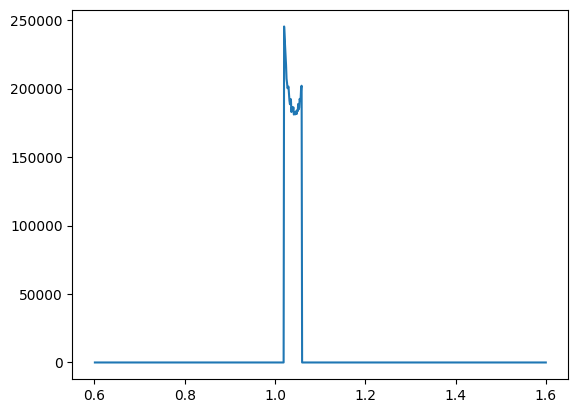

In [68]:
df_rt_values = bin_intensities(data, "mobility_values")
plt.plot(df_rt_values["x"], df_rt_values["y"])

## Aufspalten der Bins

In [69]:
from skimage import morphology
def divide_bins(df):
    data_y = np.asarray(df["y"])
    # logische verknüpfung für Tal
    up_hill = data_y[1:] >= data_y[:-1]
    up_hill = np.append(up_hill, True)
    down_hill = data_y[:-1] >= data_y[1:]
    down_hill = np.insert(down_hill, 0, True)
    # Schwellwert für Berge (da Plateau und flaches Land nicht als Berge gelten) -> kein Problem bei der Randverteilung
    #threshold = 1e7
    # Closing, um einzelne Löcher zu schließen (wahrscheinlich Datenfehler) -> keine gute Idee, da auch Berge zusammengeschlossen werden (einzelne Fehler werden in der Masse verschluckt)
    #import scipy.ndimage.morphology as morph
    #data_y = morph.binary_closing(data_y)

    # Regionen separieren
    gaps = up_hill & down_hill
    labels = morphology.label(gaps)

    # Regionen in DataFrame speichern
    # muss glaube ich nicht, die Label sollten reichen

    return labels

## Erstellen einer Datenbank

1. **LC**: rt_values, frame_indices
2. **TIMS**: mobility_values, scan_indices
3. **QUAD**: quad_mz_values, precursor_indices
4. **TOF**: mz_values, tof_indices
5. **DETECTOR**: intensity_values

In [70]:
from sqlalchemy import create_engine, text
from sqlalchemy_utils import database_exists, create_database
name_database = "testdata_subset"
engine = create_engine('sqlite:///../Databases/%s.db' % name_database) # drei Backslash für relativen Pfad

def save_peak_region(df):
    # restrict columns
    df_stored = df[["rt_values", "frame_indices", "mz_values", "tof_indices", "mobility_values", "scan_indices", "intensity_values", "corrected_intensity_values"]]

    # get highest peak_region_number
    with engine.connect() as conn:
        try:
            peak_region_number = conn.execute(text("SELECT MAX(peak_region) FROM %s" % name_dataset)).fetchone()[0]
        except:
            peak_region_number = 0
        df_stored["peak_region"] = peak_region_number + 1

        # save to database
        df_stored.to_sql(name_dataset, con=engine, if_exists='append')

In [71]:
# für jede der Variablen eine Liste an Bins erstellen
columns = ["rt_values", "mz_values", "mobility_values"]

for column in columns:
    print(column)
    df = bin_intensities(data, column)
    exec("df_%s = df" % column)
    exec("labels_%s = divide_bins(df)" % column)

rt_values
mz_values
mobility_values


In [72]:
rt_lower = 11.7
rt_upper = 12.4
mobility_lower = 1.02
mobility_upper = 1.06
mz_lower = 710.0
mz_upper = 750.0

In [ ]:
# Alle Kombinationen der verschiedenen Bins durchgehen
for label_rt in labels_rt_values:
    if label_rt == 0:
        continue
    data_rt = data[labels_rt_values == label_rt]
    data_rt = data_rt[(rt_lower < data_rt["rt_values"]) & (data_rt["rt_values"] < rt_upper)]
    for label_mz in labels_mz_values:
        if label_mz == 0:
            continue
        data_mz = data[labels_mz_values == label_mz]
        data_mz = data_mz[(mz_lower < data_mz["mz_values"]) & (data_mz["mz_values"] < mz_upper)]
        for label_mobility in labels_mobility_values:
            if label_mobility == 0:
                continue
            data_mobility = data[labels_mobility_values == label_mobility]
            data_mobility = data_mobility[(mobility_lower < data_mobility["mobility_values"]) & (data_mobility["mobility_values"] < mobility_upper)]
            # Sind genug Daten in vermuteter Region vorhanden, dann speichere die Daten als Peakgebiet in Datenbank
            data_rt_mz = pd.merge(data_rt, data_mz["rt_values"], how='inner', on=["rt_values"])
            data_rt_mz_mobility = pd.merge(data_rt_mz, data_mobility["mobility_values"], how='inner', on=["mobility_values"])

            if len(data_rt_mz_mobility) > 20: # enough data points
                save_peak_region(data_rt_mz_mobility)

In [78]:
data[labels_mz_values == 2]

,raw_indices,frame_indices,scan_indices,precursor_indices,push_indices,tof_indices,rt_values,rt_values_min,mobility_values,quad_low_mz_values,quad_high_mz_values,mz_values,intensity_values,corrected_intensity_values
0,17133,5,566,1,5206,135277,1.008982,0.016816,0.990086,620.081834,622.081834,428.841728,143,143
1,17134,5,567,1,5207,129727,1.008982,0.016816,0.989009,620.081834,622.081834,410.838745,161,161
2,17135,5,568,1,5208,130036,1.008982,0.016816,0.987931,620.081834,622.081834,411.830925,182,182
3,17136,5,569,1,5209,118244,1.008982,0.016816,0.986853,620.081834,622.081834,374.816028,148,148
4,17137,5,570,1,5210,129725,1.008982,0.016816,0.985776,620.081834,622.081834,410.832327,108,108
5,17138,5,571,1,5211,140716,1.008982,0.016816,0.984698,620.081834,622.081834,446.859182,158,158
6,17139,5,572,1,5212,160023,1.008982,0.016816,0.983621,620.081834,622.081834,513.810179,103,103
7,17140,5,574,1,5214,143071,1.008982,0.016816,0.981466,620.081834,622.081834,454.775467,151,151
8,17141,5,575,1,5215,130077,1.008982,0.016816,0.980388,620.081834,622.081834,411.962663,11,11
9,17142,5,580,1,5220,152951,1.008982,0.016816,0.975000,620.081834,622.081834,488.744369,59,59
